# This jupyter notebook provides various analysis about shear results

In [155]:
%aiida
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## imports and settings

In [156]:
import os
import yaml
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
from aiidaplus.plot import line_chart, band_plot, band_plots
from aiidaplus.get_data import get_phonon_data
from aiidaplus.utils import (get_qpoints_from_band_labels,
                             get_default_labels_of_twinmode)

shear_dir = os.path.join('..', 'data', 'shear')

## extract yaml files

In [157]:
yamlfiles = [ name for name in os.listdir(shear_dir) if 'yaml' in name ]
yamlfiles.sort()
shears = []
for yamlfile in yamlfiles:
    with open(os.path.join(shear_dir, yamlfile)) as f:
        shears.append(yaml.load(f, Loader=yaml.SafeLoader))

## data details

In [158]:
print("# keys of each shear data")
print(shears[0].keys())
print("")

print("# calculator_settings")
pprint(shears[0]['calculator_settings'])
print("")

for key in ['parent', 'phonon_pks', 'relax_pks', 'relax_results', 'shear_conf', 'shear_ratios', 'strain']:
    print("# "+key)
    pprint(shears[0][key])
    print("")

# keys of each shear data
dict_keys(['calculator_settings', 'parent', 'phonon_pks', 'pk', 'relax_pks', 'relax_results', 'shear_conf', 'shear_ratios', 'strain'])

# calculator_settings
{'phonon': {'incar_settings': {'addgrid': True,
                               'ediff': 1e-08,
                               'encut': 300,
                               'gga': 'PS',
                               'ialgo': 38,
                               'ismear': 1,
                               'kpar': 2,
                               'lcharg': False,
                               'lreal': False,
                               'lwave': False,
                               'npar': 4,
                               'prec': 'Accurate',
                               'sigma': 0.2},
            'kpoints': {'mesh': [5, 5, 5], 'offset': [0, 0, 0.5]},
            'options': {'max_wallclock_seconds': 36000, 'queue_name': ''},
            'phonon_conf': {'distance': 0.02,
                            'mesh

## energies

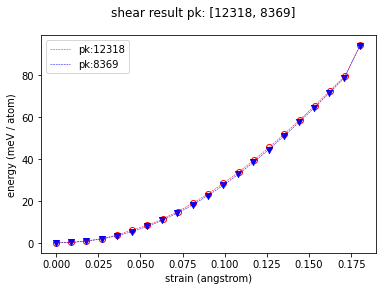

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111)
pks = []
for shear in shears:
    pks.append(shear['pk'])
    line_chart(
            ax,
            shear['strain'] * np.array(shear['shear_ratios']),
            (np.array(shear['relax_results']['energies']) \
                - shear['relax_results']['energies'][0]) \
                  * 1000 / shear['parent']['natoms'],
            "strain (angstrom)",
            "energy (meV / atom)",
            label = 'pk:' + str(shear['pk'])
            )
ax.legend()
fig.suptitle('shear result pk: %s' % pks)
plt.show()

## band strcutures

In [ ]:
labels = get_default_labels_of_twinmode(shears[0]['shear_conf']['twinmode'])
pmgstructure = load_node(shears[0]['parent']['pk']).get_pymatgen_structure()
qpoints = get_qpoints_from_band_labels(pmgstructure, labels)

shear_phonons = []
for shear in shears:
    phonons = []
    for pk in shear['phonon_pks']:
        try:
            _, phonon = get_phonon_data(pk, get_phonon=True)
        except:
            print("phonon calc seems to have failed pk:{}".format(pk))
        phonons.append(phonon)
    shear_phonons.append(phonons)

phonon calc seems to have failed pk:13982
phonon calc seems to have failed pk:14193


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
band_plots(ax, shear_phonons[0][0:2], band_labels=labels, segment_qpoints=qpoints)
# band_plot(ax, shear_phonons[0][0], is_auto=True)

# band path is set automalically


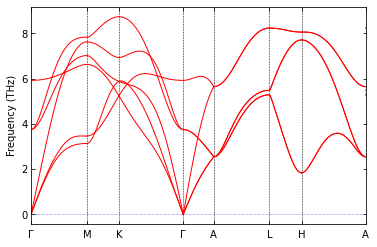

In [154]:
fig = plt.figure()
ax = fig.add_subplot(111)
band_plots(ax, [shear_phonons[0][0]], is_auto=True)

In [165]:
print([ distance.shape for distance in distances ])
print([ base_distance.shape for base_distance in base_distances ])

[(68,), (55,), (68,), (101,), (55,), (101,)]
[(101,), (48,), (101,), (87,), (48,), (87,)]


In [188]:
segment_lengths

[[0.1335736603447281,
  0.10864415052480553,
  0.13357366034472826,
  0.19968698795697076,
  0.10864415052480814,
  0.1996869879569707],
 [0.2303188575445012,
  0.10913352339038335,
  0.2303188575444996,
  0.19946198156685635,
  0.10913352339038163,
  0.19946198156685246]]

In [192]:
segment_lengths = []
for ds in [distances, base_distances]:
    lengths = []
    init = 0
    for d in ds:
        lengths.append(d[-1]-init)
        init = d[-1]
    segment_lengths.append(lengths)
ratios = np.array(segment_lengths)[0] /  np.array(segment_lengths)[1]
revised = []
seg_start = 0
for i, distance in enumerate(distances):
    if i == 0:
        revised.append(distance / ratios[i])
    else:
        revised.append(seg_start+(distance-distances[i-1][-1]) / ratios[i])
    seg_start = revised[-1][-1]

In [193]:
for i in range(len(base_distances)):
    print(base_distances[i][-1])
    print(revised[i][-1])

0.2303188575445012
0.23031885754450118
0.33945238093488456
0.3394523809348845
0.5697712384793842
0.569771238479384
0.7692332200462405
0.7692332200462404
0.8783667434366221
0.878366743436622
1.0778287250034746
1.0778287250034744
